In [1]:
import pickle
import json  # 存loss, acc
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

#################################################
import cv2
# import matplotlib.pyplot as plt
import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time

In [2]:
# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

### Data Preprocessing

In [6]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (32, 32))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

##########################################################################################################
# def FlattenImages(image: np.ndarray) -> np.ndarray:
#     return image.flatten()

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     flatten_resized_train_imgs = np.array(pool.map(FlattenImages, tqdm(resized_train_imgs)))
#     flatten_resized_val_imgs = np.array(pool.map(FlattenImages, tqdm(resized_val_imgs)))
#     flatten_resized_test_imgs = np.array(pool.map(FlattenImages, tqdm(resized_test_imgs)))


# # Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# # extract rgb features
# def ExtractColorHistFeatures(image):
#     features = []
#     for channel in range(3):
#         hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[64], ranges=[0,256])
#         hist = cv2.normalize(hist, hist)
#         # features.extend(hist)
#         features.append(hist)
#     return features

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     ### tqdm returns an iterator
#     # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
#     # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
#     # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
#     train_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_train_imgs), total=len(resized_train_imgs)))
#     val_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_val_imgs), total=len(resized_val_imgs)))
#     test_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_test_imgs), total=len(resized_test_imgs)))


# # flatten and reshape the features into (n_samples, n_features)
# train_features = np.array(train_features)
# val_features = np.array(val_features)
# test_features = np.array(test_features)

# def FlattenFeatures(feature):
#     return feature.flatten()

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
#     val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
#     test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

# # flatten and reshape the features into (n_samples, n_features)
# resized_train_imgs = np.array(resized_train_imgs)
# resized_val_imgs = np.array(resized_val_imgs)
# resized_test_imgs = np.array(resized_test_imgs)

# def FlattenImages(image):
#     return image.flatten()

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     resized_train_imgs = np.array(pool.map(FlattenImages, tqdm(resized_train_imgs)))
#     resized_val_imgs = np.array(pool.map(FlattenImages, tqdm(resized_val_imgs)))
#     resized_test_imgs = np.array(pool.map(FlattenImages, tqdm(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 2009.20it/s]


In [7]:
np.save(file="./data/resized_train_imgs.npy", arr=resized_train_imgs)
np.save(file="./data/resized_val_imgs.npy", arr=resized_val_imgs)
np.save(file="./data/resized_test_imgs.npy", arr=resized_test_imgs)
np.save(file="./data/train_label", arr=train_label)
np.save(file="./data/val_label", arr=val_label)
np.save(file="./data/test_label", arr=test_label)

In [3]:
resized_train_imgs = np.load(file="./data/resized_train_imgs.npy")
resized_val_imgs = np.load(file="./data/resized_val_imgs.npy")
resized_test_imgs = np.load(file="./data/resized_test_imgs.npy")
train_label = np.load(file="./data/train_label.npy")
val_label = np.load(file="./data/val_label.npy")
test_label = np.load(file="./data/test_label.npy")

In [4]:
def MoveColorChannel(image: np.ndarray) -> np.ndarray:
    return np.moveaxis(image, source=2, destination=0)  # reshape (H, W, C) to (C, H, W)

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(MoveColorChannel, tqdm(resized_train_imgs))
    resized_val_imgs = pool.map(MoveColorChannel, tqdm(resized_val_imgs))
    resized_test_imgs = pool.map(MoveColorChannel, tqdm(resized_test_imgs))


100%|██████████| 450/450 [00:00<00:00, 50121.80it/s]


In [5]:
# # shuffle
# def shuffle(imgs: list, label: list) -> list:
#     random.seed(42)
#     idx = np.arange(len(imgs))
#     random.shuffle(idx)
#     imgs = [imgs[i] for i in idx]
#     label = [label[i] for i in idx]
#     return imgs, label

# resized_train_imgs, train_label = shuffle(resized_train_imgs, train_label)
# resized_val_imgs, val_label = shuffle(resized_val_imgs, val_label)
# resized_test_imgs, test_label = shuffle(resized_test_imgs, test_label)

# convert list to numpy.ndarray
resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)
# list to numpy.ndarray
train_label = np.array(train_label)
val_label = np.array(val_label)
test_label = np.array(test_label)

In [6]:
# check the shape
print(resized_train_imgs.shape)
print(resized_val_imgs.shape)
print(resized_test_imgs.shape)
print()
print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

(63325, 3, 32, 32)
(450, 3, 32, 32)
(450, 3, 32, 32)

(63325,)
(450,)
(450,)


In [7]:
# filename = [
# 	["training_images","train-images-idx3-ubyte.gz"],
# 	["test_images","t10k-images-idx3-ubyte.gz"],
# 	["training_labels","train-labels-idx1-ubyte.gz"],
# 	["test_labels","t10k-labels-idx1-ubyte.gz"]
# ]

# def download_mnist():
#     base_url = "http://yann.lecun.com/exdb/mnist/"
#     for name in filename:
#         print("Downloading "+name[1]+"...")
#         request.urlretrieve(base_url+name[1], name[1])
#     print("Download complete.")

# def save_mnist():
#     mnist = {}
#     for name in filename[:2]:
#         with gzip.open(name[1], 'rb') as f:
#             mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
#     for name in filename[-2:]:
#         with gzip.open(name[1], 'rb') as f:
#             mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
#     with open("mnist.pkl", 'wb') as f:
#         pickle.dump(mnist,f)
#     print("Save complete.")

# def init():
#     download_mnist()
#     save_mnist()

# def load():
#     with open("./lenet-5-mnist-from-scratch-numpy/mnist.pkl",'rb') as f:
#         mnist = pickle.load(f)
#     return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]



In [8]:
def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

class FC():
    """
    Fully connected layer
    """
    def __init__(self, D_in, D_out):
        #print("Build FC")
        self.cache = None
        #self.W = {'val': np.random.randn(D_in, D_out), 'grad': 0}
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        #print("FC: _forward")
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        #print("FC: _backward")
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

class ReLU():
    """
    ReLU activation layer
    """
    def __init__(self):
        #print("Build ReLU")
        self.cache = None

    def _forward(self, X):
        #print("ReLU: _forward")
        out = np.maximum(0, X)
        self.cache = X
        return out

    def _backward(self, dout):
        #print("ReLU: _backward")
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

class Sigmoid():
    """
    Sigmoid activation layer
    """
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        self.cache = X
        return 1 / (1 + np.exp(-X))

    def _backward(self, dout):
        X = self.cache
        X = self._forward(X)  # 與原作者不同，新增這行
        dX = dout*X*(1-X)
        return dX

class tanh():
    """
    tanh activation layer
    """
    def __init__(self):
        self.cache = X

    def _forward(self, X):
        self.cache = X
        return np.tanh(X)

    def _backward(self, X):
        X = self.cache
        dX = dout*(1 - np.tanh(X)**2)
        return dX

class Softmax():
    """
    Softmax activation layer
    """
    def __init__(self):
        #print("Build Softmax")
        self.cache = None

    def _forward(self, X):
        #print("Softmax: _forward")
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z # distribution

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX


class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def _forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def _backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

class Conv():
    """
    Conv layer
    """
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        #self.W = {'val': np.random.randn(Cout, Cin, F, F), 'grad': 0}
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        # for n in range(N):
        #     for c in range(self.Cout):
        #         for h in range(H_):
        #             for w in range(W_):
        #                 Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :]) + self.b['val'][c]

        for c in range(self.Cout):
            for h in range(H_):
                for w in range(W_):
                    Y[:, c, h, w] = np.sum(X[:, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :], axis=(1, 2, 3)) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        # self.W['grad'] = dW
        # self.b['grad'] = db

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        # for n in range(N):
        #     for ci in range(Cin):
        #         for h in range(H):
        #             for w in range(W):
        #                 #print("self.F.shape: %s", self.F)
        #                 #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
        #                 dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        for ci in range(Cin):
            for h in range(H):
                for w in range(W):
                    #print("self.F.shape: %s", self.F)
                    #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                    dX[:, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[:, :, h:h+self.F,w:w+self.F], axis=(1, 2, 3))

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        # for n in range(N):
        #     for cin in range(Cin):
        #         for w_ in range(W_):
        #             for h_ in range(H_):
        #                 Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
        #                 i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
        #                 M[n,cin,F*w_+i,F*h_+j] = 1
        
        for cin in range(Cin):
            for w_ in range(W_):
                for h_ in range(H_):
                    Y[:,cin,w_,h_] = np.max(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)], axis=(1, 2))
                    i,j = np.unravel_index(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].reshape(N, -1).argmax(axis=1), (F,F))
                    M[:,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        # for n in range(N):
        #     for c in range(Cin):
        #         #print("(n,c): (%s,%s)" % (n,c))
        #         dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)

        for c in range(Cin):
            #print("(n,c): (%s,%s)" % (n,c))
            dX[:,c,:,:] = dout[:,c,:,:].repeat(2, axis=1).repeat(2, axis=2)
        return dX*M

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class SoftmaxLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        loss = NLLLoss(Y_pred, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = Y_pred.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass


class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 5)
        self.Sigmoid1 = Sigmoid()
        self.pool1 = MaxPool(2,2)
        self.conv2 = Conv(6, 16, 5)
        self.Sigmoid2 = Sigmoid()
        self.pool2 = MaxPool(2,2)
        self.FC1 = FC(16*5*5, 120)  # 64: 16*13*13
        self.Sigmoid3 = Sigmoid()
        self.FC2 = FC(120, 84)
        self.Sigmoid4 = Sigmoid()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.Sigmoid1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.Sigmoid2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.Sigmoid3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.Sigmoid4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        # dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.Sigmoid4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.Sigmoid3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.Sigmoid2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.Sigmoid1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])


In [9]:
class DataLoader:
    def __init__(self, data, labels, batch_size=64, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels

In [10]:
"""
(1) Prepare Data: Load, Shuffle, Normalization, Batching, Preprocessing
"""

X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs, train_label, resized_val_imgs, val_label, resized_test_imgs, test_label
# X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs[::25,:,:,:], train_label[::25], resized_val_imgs[::25,:,:,:], val_label[::25], resized_test_imgs[::25,:,:,:], test_label[::25]
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)

batch_size = 64
# D_in = 784
D_out = 50

# print("batch_size: " + str(batch_size) + ", D_in: " + str(D_in) + ", D_out: " + str(D_out))
print("batch_size: " + str(batch_size) + ", D_out: " + str(D_out))

batch_size: 64, D_out: 50


In [11]:
def acc_fn(Y_pred, Y_true):
    return np.mean(np.argmax(Y_pred, axis=1)==np.argmax(Y_true, axis=1))

In [12]:
### Lenet Forward Test ###
model = LeNet5()
train_dataloader = DataLoader(data=X_train,
                              labels=Y_train,
                              batch_size=64,
                              shuffle=True)
val_dataloader = DataLoader(data=X_val,
                            labels=Y_val,
                            batch_size=64,
                            shuffle=True)

In [13]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
# optim = SGDMomentum(params=model.get_params(), lr=1e-3, momentum=0.99, reg=0)
optim = SGD(params=model.get_params(), lr=1e-3, reg=0)
criterion = CrossEntropyLoss()

# Train
EPOCHS = 30
for i in range(EPOCHS):
    print(f"epoch: {i+1}")
    # train
    train_loss, train_acc = 0, 0
    with tqdm(total=train_dataloader.num_batches) as pbar:
        for X_batch, Y_batch in train_dataloader:
            # get batch, make onehot
            # X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
            Y_batch = MakeOneHot(Y_batch, D_out)

            # forward, loss, backward, step
            Y_pred = model.forward(X_batch)
            loss, _ = criterion.get(Y_pred, Y_batch)  # loss, dout
            dout = Y_pred - Y_batch  # pred - label
            model.backward(dout)
            optim.step()

            # train accuracy
            acc = acc_fn(Y_pred, Y_batch)

            train_loss += loss
            train_acc += acc
            pbar.update(1)

    train_loss /= train_dataloader.num_batches
    train_acc /= train_dataloader.num_batches
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
            
    if i % 1 == 0:
        print("%s%% epoch: %s, train loss: %s" % (round(100*(i+1)/EPOCHS, 4), i+1, round(train_loss, 4)))


    # validation
    val_loss, val_acc = 0, 0
    for X_batch, Y_batch in val_dataloader:
        # get batch, make onehot
        # X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
        Y_batch = MakeOneHot(Y_batch, D_out)

        # forward, loss, backward, step
        Y_pred = model.forward(X_batch)
        loss, _ = criterion.get(Y_pred, Y_batch)  # loss, dout
        dout = Y_pred - Y_batch  # pred - label
        model.backward(dout)
        optim.step()

        # train accuracy
        acc = acc_fn(Y_pred, Y_batch)

        val_loss += loss
        val_acc += acc

    val_loss /= val_dataloader.num_batches
    val_acc /= val_dataloader.num_batches
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

epoch: 1


100%|██████████| 990/990 [17:08<00:00,  1.04s/it]


3.3333% epoch: 1, train loss: 3.9119
epoch: 2


100%|██████████| 990/990 [15:06<00:00,  1.09it/s]


6.6667% epoch: 2, train loss: 3.9116
epoch: 3


100%|██████████| 990/990 [14:54<00:00,  1.11it/s]


10.0% epoch: 3, train loss: 3.9111
epoch: 4


100%|██████████| 990/990 [14:57<00:00,  1.10it/s]


13.3333% epoch: 4, train loss: 3.9098
epoch: 5


100%|██████████| 990/990 [14:58<00:00,  1.10it/s]


16.6667% epoch: 5, train loss: 3.908
epoch: 6


100%|██████████| 990/990 [14:48<00:00,  1.11it/s]


20.0% epoch: 6, train loss: 3.9059
epoch: 7


100%|██████████| 990/990 [14:51<00:00,  1.11it/s]


23.3333% epoch: 7, train loss: 3.904
epoch: 8


100%|██████████| 990/990 [14:50<00:00,  1.11it/s]


26.6667% epoch: 8, train loss: 3.9023
epoch: 9


100%|██████████| 990/990 [14:51<00:00,  1.11it/s]


30.0% epoch: 9, train loss: 3.9001
epoch: 10


100%|██████████| 990/990 [15:58<00:00,  1.03it/s]


33.3333% epoch: 10, train loss: 3.8977
epoch: 11


100%|██████████| 990/990 [14:58<00:00,  1.10it/s]


36.6667% epoch: 11, train loss: 3.8954
epoch: 12


100%|██████████| 990/990 [14:56<00:00,  1.10it/s]


40.0% epoch: 12, train loss: 3.8934
epoch: 13


100%|██████████| 990/990 [15:24<00:00,  1.07it/s]


43.3333% epoch: 13, train loss: 3.892
epoch: 14


100%|██████████| 990/990 [15:02<00:00,  1.10it/s]


46.6667% epoch: 14, train loss: 3.8908
epoch: 15


100%|██████████| 990/990 [14:53<00:00,  1.11it/s]


50.0% epoch: 15, train loss: 3.8898
epoch: 16


100%|██████████| 990/990 [14:59<00:00,  1.10it/s]


53.3333% epoch: 16, train loss: 3.889
epoch: 17


100%|██████████| 990/990 [14:54<00:00,  1.11it/s]


56.6667% epoch: 17, train loss: 3.8884
epoch: 18


100%|██████████| 990/990 [14:50<00:00,  1.11it/s]


60.0% epoch: 18, train loss: 3.8877
epoch: 19


100%|██████████| 990/990 [15:39<00:00,  1.05it/s]


63.3333% epoch: 19, train loss: 3.8871
epoch: 20


100%|██████████| 990/990 [14:56<00:00,  1.10it/s]


66.6667% epoch: 20, train loss: 3.8864
epoch: 21


100%|██████████| 990/990 [14:59<00:00,  1.10it/s]


70.0% epoch: 21, train loss: 3.8858
epoch: 22


100%|██████████| 990/990 [14:47<00:00,  1.12it/s]


73.3333% epoch: 22, train loss: 3.8853
epoch: 23


100%|██████████| 990/990 [14:56<00:00,  1.10it/s]


76.6667% epoch: 23, train loss: 3.8848
epoch: 24


100%|██████████| 990/990 [15:11<00:00,  1.09it/s]


80.0% epoch: 24, train loss: 3.8843
epoch: 25


100%|██████████| 990/990 [16:15<00:00,  1.01it/s]


83.3333% epoch: 25, train loss: 3.8839
epoch: 26


100%|██████████| 990/990 [14:44<00:00,  1.12it/s]


86.6667% epoch: 26, train loss: 3.8835
epoch: 27


100%|██████████| 990/990 [14:43<00:00,  1.12it/s]


90.0% epoch: 27, train loss: 3.8829
epoch: 28


100%|██████████| 990/990 [15:31<00:00,  1.06it/s]


93.3333% epoch: 28, train loss: 3.8825
epoch: 29


100%|██████████| 990/990 [14:46<00:00,  1.12it/s]


96.6667% epoch: 29, train loss: 3.8822
epoch: 30


100%|██████████| 990/990 [14:49<00:00,  1.11it/s]


100.0% epoch: 30, train loss: 3.8817


In [14]:
# save params
weights = model.get_params()
with open("modified_weights.pkl","wb") as f:
	pickle.dump(weights, f)

# save loss, accuracy
with open("./loss/modified_train_losses.txt", "w") as fp:
	json.dump(train_losses, fp)
with open("./loss/modified_val_losses.txt", "w") as fp:
	json.dump(val_losses, fp)
with open("./acc/modified_train_accuracy.txt", "w") as fp:
	json.dump(train_accuracy, fp)
with open("./acc/modified_val_accuracy.txt", "w") as fp:
	json.dump(val_accuracy, fp)


In [15]:
# load params
with open("modified_weights.pkl", "rb") as f:
	model.set_params(params=pickle.load(f))

# load loss, accuracy
with open("./loss/modified_train_losses.txt", "r") as fp:
	train_losses = json.load(fp)
with open("./loss/modified_val_losses.txt", "r") as fp:
	val_losses = json.load(fp)
with open("./acc/modified_train_accuracy.txt", "r") as fp:
	train_accuracy = json.load(fp)
with open("./acc/modified_val_accuracy.txt", "r") as fp:
	val_accuracy = json.load(fp)

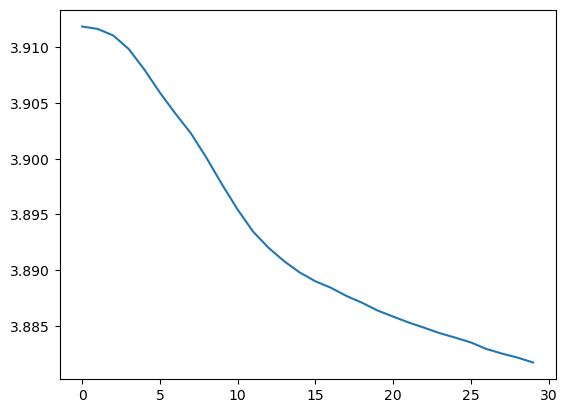

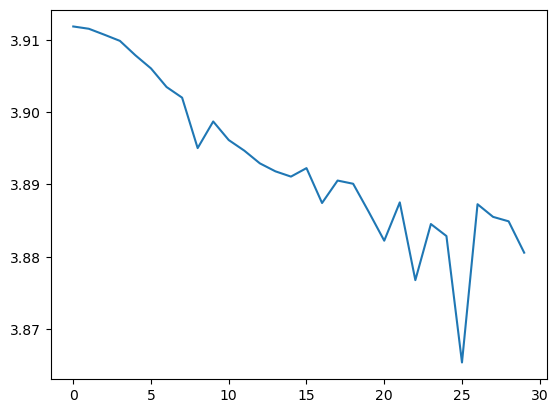

In [15]:
# draw train loss
draw_losses(train_losses)
# draw val loss
draw_losses(val_losses)

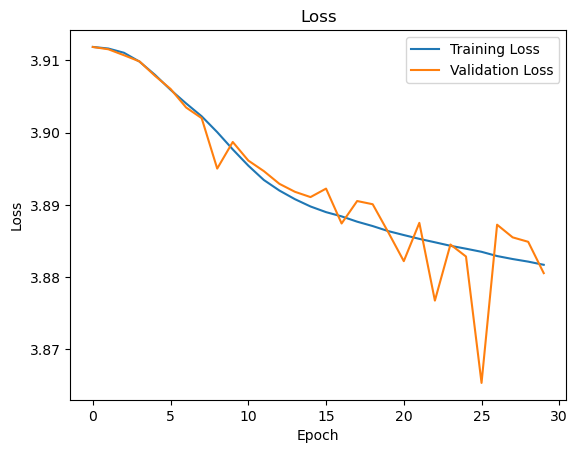

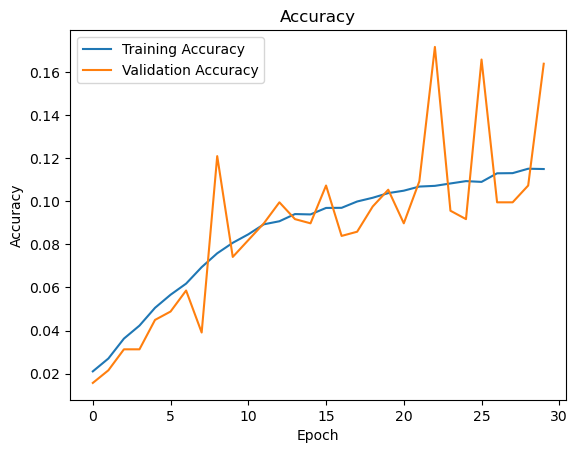

In [16]:
def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./pic/ModifiedLeNet5_loss.png')
    plt.show()
    
def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./pic/ModifiedLeNet5_acc.png')
    plt.show()
    
draw_losses(train_losses=train_losses, val_losses=val_losses)
draw_accuracy(train_acc=train_accuracy, val_acc=val_accuracy)

In [17]:
# # TRAIN SET ACC
# Y_pred = model.forward(X_train)
# result = np.argmax(Y_pred, axis=1) - Y_train
# result = list(result)
# print("TRAIN--> Correct: " + str(result.count(0)) + " out of " + str(X_train.shape[0]) + ", acc=" + str(result.count(0)/X_train.shape[0]))

# VALIDATION SET ACC
Y_pred = model.forward(X_val)
result = np.argmax(Y_pred, axis=1) - Y_val
result = list(result)
print("VALIDATION--> Correct: " + str(result.count(0)) + " out of " + str(X_val.shape[0]) + ", acc=" + str(result.count(0)/X_val.shape[0]))

# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


VALIDATION--> Correct: 55 out of 450, acc=0.12222222222222222
TEST--> Correct: 60 out of 450, acc=0.13333333333333333


In [18]:
# TRAIN SET ACC
Y_pred = model.forward(X_train)
result = np.argmax(Y_pred, axis=1) - Y_train
result = list(result)
print("TRAIN--> Correct: " + str(result.count(0)) + " out of " + str(X_train.shape[0]) + ", acc=" + str(result.count(0)/X_train.shape[0]))

# VALIDATION SET ACC
Y_pred = model.forward(X_val)
result = np.argmax(Y_pred, axis=1) - Y_val
result = list(result)
print("VALIDATION--> Correct: " + str(result.count(0)) + " out of " + str(X_val.shape[0]) + ", acc=" + str(result.count(0)/X_val.shape[0]))

# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


TRAIN--> Correct: 3362 out of 63325, acc=0.053091196210027634
VALIDATION--> Correct: 31 out of 450, acc=0.06888888888888889
TEST--> Correct: 27 out of 450, acc=0.06
